In [1]:
import sys
!{sys.executable} --version

import os
import math
from math import log
# import pickle
import numpy as np
from hurst import compute_Hc
from arch import arch_model
from IPython.display import display
import matplotlib.pyplot as plt

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from IPython.display import display

%matplotlib inline

from quantile_functions import *
from VaR_backtest_tests import *

# prices = pickle.load(open('stock_prices.pkl','rb'))

# # convert from prices to returns
# returns = dict()
# for k in list(prices.keys()):
#     returns[k] = get_stock_log_returns(prices[k])

Python 3.7.4


C:\Users\Elliot\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# download price history

In [2]:
# https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
# two most recently added stocks to the Dow Jones index and are listed on the NYSE
companies, tickers = ['Facebook','Amazon','Apple','Netflix','Google'],['FB','AMZN','AAPL','NFLX','GOOG']

tickers_df = yf.download(tickers, 
                      start='2017-01-01', 
                      end='2021-09-04', # set to next day to get prices to 8/29/2020
                      progress=False, auto_adjust=True)
display(tickers_df.head())
display(tickers_df.tail())

Close                                                  \
                 AAPL        AMZN          FB        GOOG        NFLX   
Date                                                                    
2017-01-03  27.372362  753.669983  116.860001  786.140015  127.489998   
2017-01-04  27.341724  757.179993  118.690002  786.900024  129.410004   
2017-01-05  27.480770  780.450012  120.669998  794.020020  131.809998   
2017-01-06  27.787130  795.989990  123.410004  806.150024  131.070007   
2017-01-09  28.041647  796.919983  124.900002  806.650024  130.949997   

                 High                                                  ...  \
                 AAPL        AMZN          FB        GOOG        NFLX  ...   
Date                                                                   ...   
2017-01-03  27.414782  758.760010  117.839996  789.630005  128.190002  ...   
2017-01-04  27.457201  759.679993  119.660004  791.340027  130.169998  ...   
2017-01-05  27.539686  782.400024  120.949997  794.479980  132.750000  ...   
2017-01-06  27.846046  799.440002  123.879997  807.900024  133.880005  ...   
2017-01-09  28.145340  801.770020  125.430000  809.966003  131.990005  ...   

                 Open                                                  \
                 AAPL        AMZN          FB        GOOG        NFLX   
Date                                                                    
2017-01-03  27.289880  757.919983  116.029999  778.809998  124.959999   
2017-01-04  27.301662  758.390015  117.550003  788.359985  127.489998   
2017-01-05  27.318161  761.549988  118.860001  786.080017  129.220001   
2017-01-06  27.520829  782.359985  120.980003  795.260010  132.080002   
2017-01-09  27.796556  798.000000  123.550003  806.400024  131.479996   

               Volume                                        
                 AAPL     AMZN        FB     GOOG      NFLX  
Date                                                         
2017-01-03  115127600  3521100  20663900  1657300   9437900  
2017-01-04   84472400  2510500  19630900  1073000   7843600  
2017-01-05   88774400  5830100  19492200  1335200  10185500  
2017-01-06  127007600  5986200  28545300  1640200  10657900  
2017-01-09  134247600  3446100  22880400  1274600   5771800  

[5 rows x 25 columns]

Close                                                    \
                  AAPL         AMZN          FB         GOOG        NFLX   
Date                                                                       
2021-08-30  153.119995  3421.570068  380.660004  2909.389893  566.179993   
2021-08-31  151.830002  3470.790039  379.380005  2909.239990  569.190002   
2021-09-01  152.509995  3479.000000  382.049988  2916.840088  582.070007   
2021-09-02  153.649994  3463.120117  375.279999  2884.379883  588.549988   
2021-09-03  154.300003  3478.050049  376.260010  2895.500000  590.530029   

                  High                                                    ...  \
                  AAPL         AMZN          FB         GOOG        NFLX  ...   
Date                                                                      ...   
2021-08-30  153.490005  3445.000000  381.489990  2929.790039  567.159973  ...   
2021-08-31  152.800003  3472.580078  382.760010  2922.239990  569.479980  ...   
2021-09-01  154.979996  3527.000000  384.329987  2936.409912  591.000000  ...   
2021-09-02  154.720001  3511.959961  381.750000  2926.500000  598.760010  ...   
2021-09-03  154.630005  3482.669922  377.160004  2907.540039  591.880005  ...   

                  Open                                                    \
                  AAPL         AMZN          FB         GOOG        NFLX   
Date                                                                       
2021-08-30  149.000000  3357.429932  372.559998  2894.090088  557.250000   
2021-08-31  152.660004  3424.800049  379.950012  2917.689941  566.119995   
2021-09-01  152.830002  3496.399902  379.589996  2913.000000  569.000000   
2021-09-02  153.869995  3494.760010  381.500000  2918.989990  583.679993   
2021-09-03  153.759995  3452.000000  374.750000  2882.919922  585.799988   

              Volume                                       
                AAPL     AMZN        FB     GOOG     NFLX  
Date                                                       
2021-08-30  90956700  3192200  13547300   845800  2434800  
2021-08-31  86453100  4356400  12345400  1337800  2431900  
2021-09-01  80313700  3629900  11567200   791200  5626200  
2021-09-02  71115500  2923700  14832900  1092200  6179900  
2021-09-03  57808700  2575700   7509600   955200  2681200  

[5 rows x 25 columns]

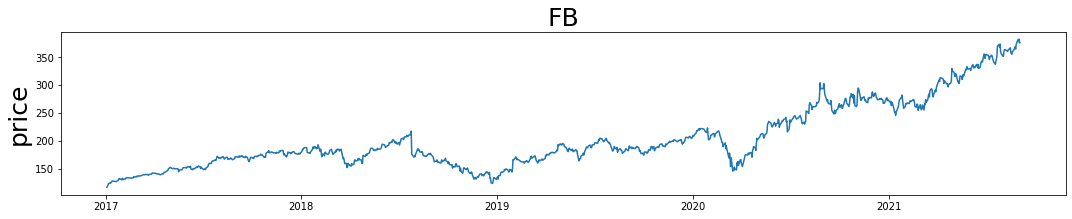

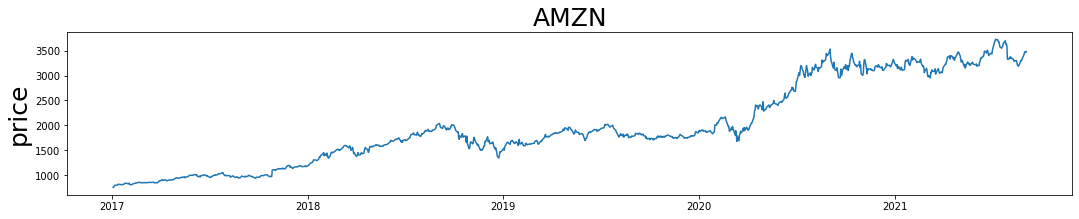

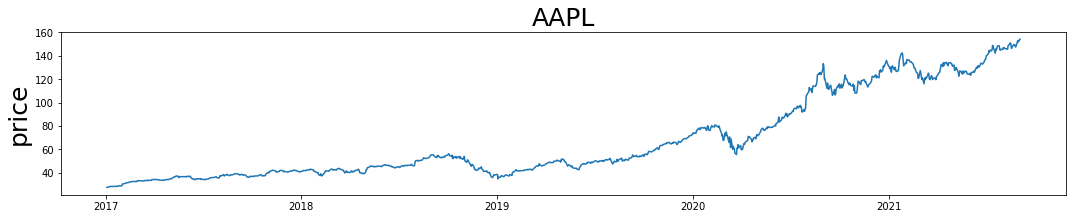

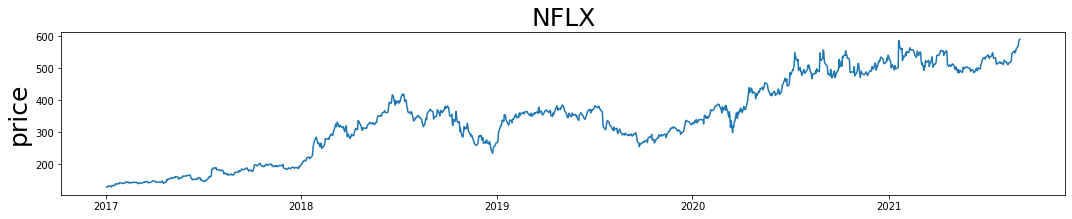

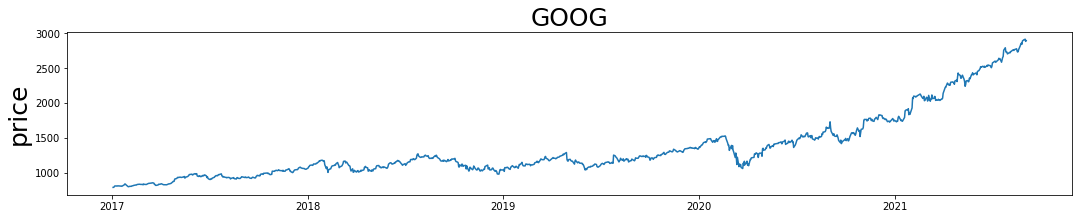

In [3]:
prices = dict()
for ticker in tickers:
    prices[ticker] = tickers_df['Close',ticker]

    plt.figure(figsize=(18,3))
    plt.plot(prices[ticker])
    plt.title(ticker, fontsize=25)
    plt.ylabel('price', fontsize=25)             
    plt.show()

# plot daily returns

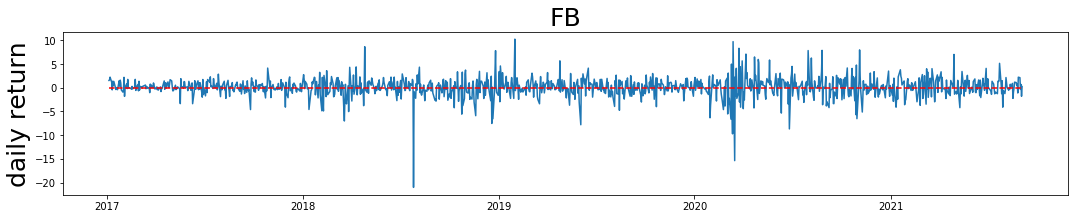

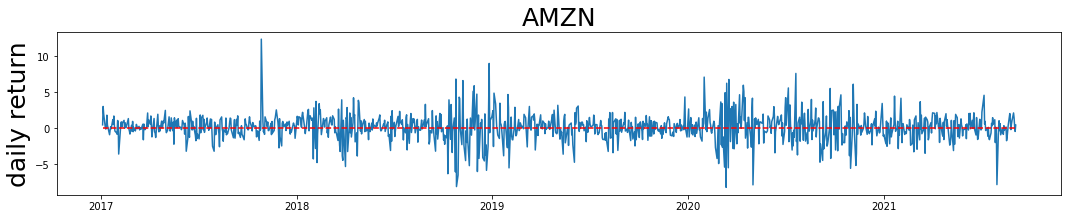

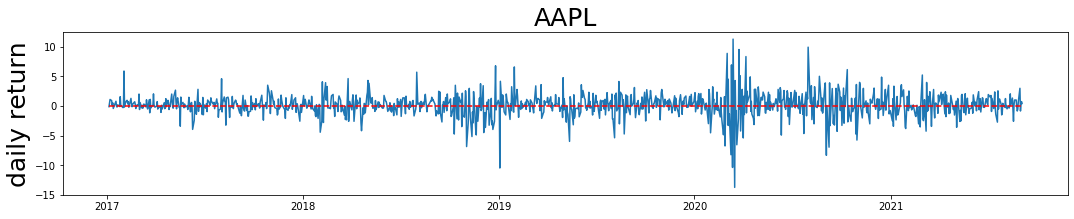

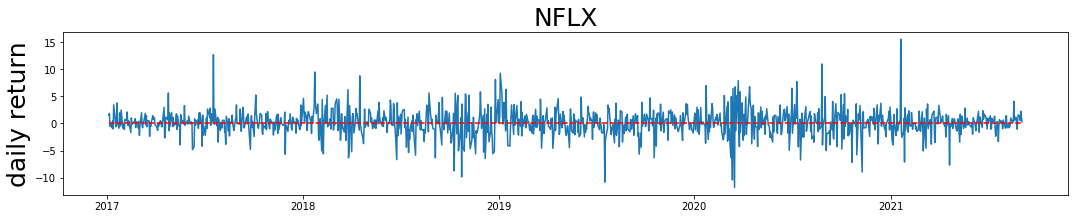

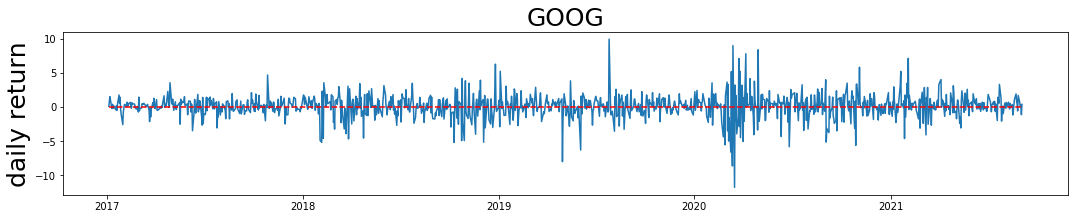

In [4]:
returns = dict() 
for ticker in tickers:
    returns[ticker] = tickers_df['Close', ticker].apply(log).diff()[1:]
    train = returns[ticker] * 100
    train2 = train * train

    plt.figure(figsize=(18,3))
    plt.plot(train)
    plt.title(ticker, fontsize=25)
    plt.plot([train.index[0], train.index[-1]], [0,0], '--',color='red')
    plt.ylabel('daily return', fontsize=25) 
    plt.show()

# Historical return statistics
## calculate skew and kurtosis and test normality using the Jarque-Bera test

In [5]:
from math import sqrt
from scipy.stats import chi2

p_level = 0.95
chi2df1, chi2df2 = chi2.ppf([p_level], df=1), chi2.ppf([p_level], df=2)

return_stats = pd.DataFrame(returns).agg(['mean','std','skew','kurt','count']).transpose()
return_stats['skew_test'] = [t / 6 * s * s for s,t in zip(return_stats['skew'], return_stats['count'])]
return_stats['kurt_test'] = [t / 24 * (k - 3) * (k - 3) for k,t in zip(return_stats['kurt'], return_stats['count'])]
return_stats['JB_test'] = return_stats['skew_test'] + return_stats['kurt_test']

return_stats['JB'] = ['sig' if kt > chi2df2 else ' ' for kt in return_stats['JB_test']]
return_stats['skew_chi2'] = ['sig' if kt > chi2df1 else ' ' for kt in return_stats['skew_test']]
return_stats['kurt_chi2'] = ['sig' if kt > chi2df1 else ' ' for kt in return_stats['kurt_test']]

display(return_stats)

,mean,std,skew,kurt,count,skew_test,kurt_test,JB_test,JB,skew_chi2,kurt_chi2
FB,0.000994,0.021167,-1.070475,13.176515,1176.0,224.599849,5074.511866,5299.111715,sig,sig,sig
AMZN,0.001300,0.018716,0.056145,4.418475,1176.0,0.617838,98.591505,99.209343,sig,,sig
AAPL,0.001471,0.019459,-0.352452,7.005581,1176.0,24.347655,786.189420,810.537075,sig,sig,sig
NFLX,0.001304,0.024344,0.105923,4.278815,1176.0,2.199041,80.133036,82.332077,sig,,sig
GOOG,0.001109,0.017169,-0.296047,6.332984,1176.0,17.178162,544.330393,561.508555,sig,sig,sig


### FB, AMZN, AAPL, GOOG, NFLX: fail the test of normality
### FB, AAPL, GOOG: have a left skewed distribution (heavy left tail)
### FB, AMZN, AAPL, GOOG, NFLX: have heavy tails

# plot return distribution

daily return mean = 0.001109 and standard deviation = 0.017162
nonparametric 95.0% Value at Risk = -0.0265

cutoff = -1.6449 * 0.0172 at probability 0.05

parametric 95.0% Value at Risk = -0.0282


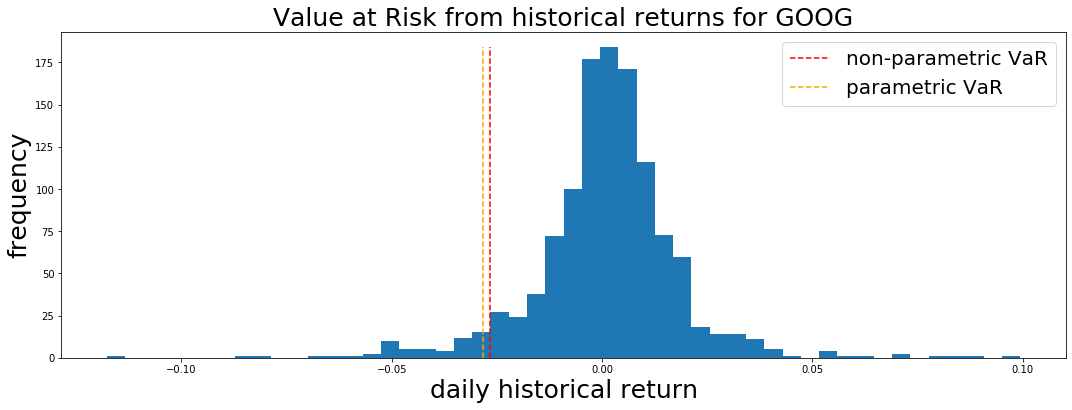

In [6]:
p = 0.05
ticker = tickers[-1]
train = returns[ticker]

from scipy.stats import norm

mu, sigma = np.mean(train), np.std(train)
print(f"daily return mean = {mu:0.6f} and standard deviation = {sigma:0.6f}")

plt.figure(figsize=(18,6))
hist = plt.hist(train,50)
plt.title(f'Value at Risk from historical returns for {ticker}', fontsize=25)
plt.xlabel('daily historical return', fontsize=25)
plt.ylabel('frequency', fontsize=25)

VaRcutoff = np.quantile(train, p)
print(f"nonparametric {100 - 100 * p}% Value at Risk = {VaRcutoff:0.4f}")
plt.plot([VaRcutoff,VaRcutoff],[0, max(hist[0])], '--',color='red', label='non-parametric VaR')

VaRcutoff = norm.ppf(p) * sigma
print(f"\ncutoff = {norm.ppf(p):0.4f} * {sigma:0.4f} at probability {p}")
print(f"\nparametric {100 - 100 * p}% Value at Risk = {VaRcutoff:0.4f}")
plt.plot([VaRcutoff,VaRcutoff],[0, max(hist[0])], '--',color='orange', label='parametric VaR')

plt.legend(fontsize=20)
plt.show()

# MA: Fit interval moving average value at risk
## 100 day moving average for 95% VaR

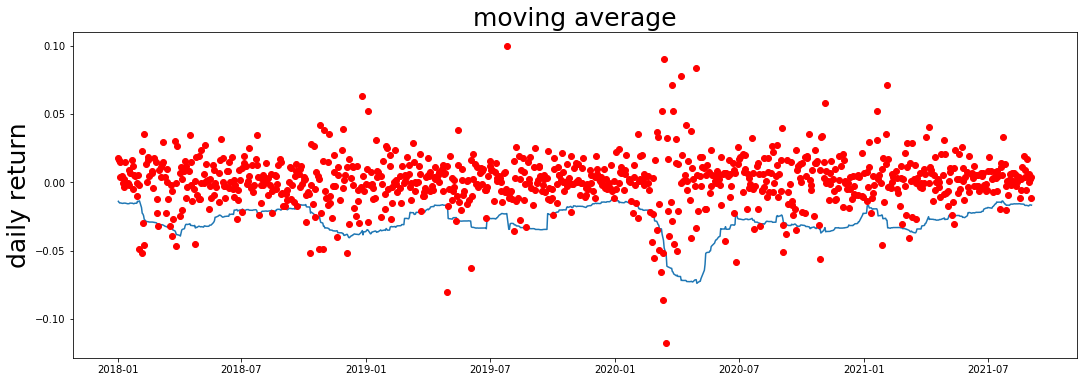

,VaR,returns
Date,,
2021-09-01,-0.016627,0.002609
2021-09-02,-0.016629,-0.011191
2021-09-03,-0.016784,0.003848


In [7]:
p = 0.05
ticker = tickers[-1]
train = returns[ticker]
train2 = train * train

history_n = 100   #40

# calculate 95% VaR
MAVaR = [-1.64 * np.sqrt(np.mean(train2[i+1:i+history_n+1])) for i,_ in enumerate(train2[:-history_n-1])]
MAVaR_df = pd.DataFrame(MAVaR[:], index=pd.DataFrame(train).index[history_n+1:], columns=['VaR'])
MAVaR_df['returns'] = train[1:]

plt.figure(figsize=(18,6))
start_date = '2018-01-01'
plt.plot(MAVaR_df[start_date:]['VaR'])
plt.plot(MAVaR_df[start_date:]['returns'], 'ro')
plt.title("moving average", fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

display(MAVaR_df[-3:])

### verify that VaR values are shifted one day

In [8]:
print(returns[ticker][-5:],'\n')

r2 = returns[ticker][-42:-2] *  returns[ticker][-42:-2]  
print('8/27 VaR (data up to 8/26) = ', -1.64 * sqrt(r2.mean()))

r2 = returns[ticker][-41:-1] *  returns[ticker][-41:-1]   
print('8/28 VaR (data up to 8/27) = ', -1.64 * sqrt(r2.mean()))

r2 = returns[ticker][-40:] *  returns[ticker][-40:]
print('8/29 VaR (data up to 8/28) = ', -1.64 * sqrt(r2.mean()))

Date
2021-08-30    0.006337
2021-08-31   -0.000052
2021-09-01    0.002609
2021-09-02   -0.011191
2021-09-03    0.003848
Name: (Close, GOOG), dtype: float64 

8/27 VaR (data up to 8/26) =  -0.01662936704367147
8/28 VaR (data up to 8/27) =  -0.016784273905227447
8/29 VaR (data up to 8/28) =  -0.016795019571379886


In [9]:
MAV2020 = MAVaR_df[MAVaR_df.index >= '2020-01-01']
MAV2020.loc[:,'exception'] = MAV2020['returns'] < MAV2020['VaR']
print(ticker, ': number of exceptions = ', MAV2020['exception'].sum(), ' out of ', MAV2020.shape[0], 'days')

GOOG : number of exceptions =  27  out of  423 days


C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [10]:
MAV2020[-5:]

,VaR,returns,exception
Date,,,
2021-08-30,-0.017351,0.006337,False
2021-08-31,-0.016760,-0.000052,False
2021-09-01,-0.016627,0.002609,False
2021-09-02,-0.016629,-0.011191,False
2021-09-03,-0.016784,0.003848,False


In [11]:
p = 0.05
for ticker in tickers:
    train = returns[ticker]
    train2 = train * train

    history_n = 40

    # calculate 95% VaR
    MAVaR = [-1.64 * np.sqrt(np.mean(train2[i+1:i+history_n+1])) for i,_ in enumerate(train2[:-history_n-1])]
    MAVaR_df = pd.DataFrame(MAVaR[:], index=pd.DataFrame(train).index[history_n+1:], columns=['VaR'])
    MAVaR_df['returns'] = train[1:]

    MAV2020 = MAVaR_df[MAVaR_df.index >= '2020-01-01']
    MAV2020.loc[:,'exception'] = MAV2020['returns'] < MAV2020['VaR']
    print(ticker, ': number of exceptions = ', MAV2020['exception'].sum(), ' out of ', MAV2020.shape[0], 'days')

C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

FB : number of exceptions =  21  out of  423 days
AMZN : number of exceptions =  20  out of  423 days
AAPL : number of exceptions =  24  out of  423 days


C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

NFLX : number of exceptions =  16  out of  423 days
GOOG : number of exceptions =  27  out of  423 days


C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# EWMA: exponential weighted moving average volatiity
$\sigma^2_n = \lambda \sigma^2_{n-1} + (1 - \lambda) u^2_{n-1}$

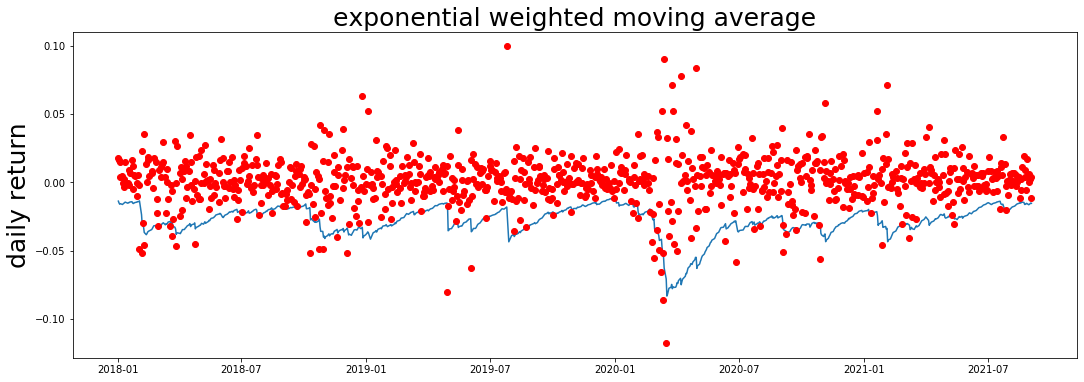

GOOG : number of exceptions =  27  out of  423 days


C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [12]:
train = returns[ticker]
train2 = train * train

wt = .94
vol = train2[0]
vol_history = [0,vol]  # move everything forward one day
for v in train2[1:]:
    vol = wt * vol + (1 - wt) * v
    vol_history.append(vol)
    
EWMA_df = pd.DataFrame(vol_history[:-1], index=train.index, columns=['vol'])
EWMA_df['VaR'] = [-1.64 * math.sqrt(x) for x in EWMA_df['vol']]
EWMA_df['returns'] = train

plt.figure(figsize=(18,6))
plt.plot(EWMA_df['2018-01-01':]['VaR'])
plt.plot(EWMA_df['2018-01-01':]['returns'], 'ro')
plt.title('exponential weighted moving average', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

EWMA2020 = EWMA_df[EWMA_df.index >= '2020-01-01']
EWMA2020.loc[:,'exception'] = EWMA2020['returns'] < EWMA2020['VaR']
print(ticker, ': number of exceptions = ', EWMA2020['exception'].sum(), ' out of ', EWMA2020.shape[0], 'days')

In [13]:
EWMA2020[:10]

,vol,VaR,returns,exception
Date,,,,
2020-01-02,0.000060,-0.012662,0.022446,False
2020-01-03,0.000086,-0.015232,-0.004919,False
2020-01-06,0.000083,-0.014899,0.024358,False
2020-01-07,0.000113,-0.017448,-0.000624,False
2020-01-08,0.000106,-0.016918,0.007849,False
2020-01-09,0.000104,-0.016703,0.010984,False
2020-01-10,0.000105,-0.016784,0.006948,False
2020-01-13,0.000101,-0.016511,0.006623,False
2020-01-14,0.000098,-0.016227,-0.005819,False


In [14]:
for ticker in tickers:
    train = returns[ticker]
    train2 = train * train

    wt = .94
    vol = train2[0]
    vol_history = [0,vol]  # move everything forward one day
    for v in train2[1:]:
        vol = wt * vol + (1 - wt) * v
        vol_history.append(vol)

    EWMA_df = pd.DataFrame(vol_history[:-1], index=train.index, columns=['vol'])
    EWMA_df['VaR'] = [-1.64 * math.sqrt(x) for x in EWMA_df['vol']]
    EWMA_df['returns'] = train

    EWMA2020 = EWMA_df[EWMA_df.index >= '2020-01-01']
    EWMA2020.loc[:,'exception'] = EWMA2020['returns'] < EWMA2020['VaR']
    print(ticker, ': number of exceptions = ', EWMA2020['exception'].sum(), ' out of ', EWMA2020.shape[0], 'days')

FB : number of exceptions =  20  out of  423 days
AMZN : number of exceptions =  21  out of  423 days
AAPL : number of exceptions =  24  out of  423 days
NFLX : number of exceptions =  20  out of  423 days
GOOG : number of exceptions =  27  out of  423 days


C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

# GARCH(1,1) model

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3057.6703600373003
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3052.242438961146
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3052.1291125264256
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3051.555408725994
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3051.2071281662584
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3050.8729255018843
Iteration:      7,   Func. Count:     43,   Neg. LLF: 3050.663316275844
Iteration:      8,   Func. Count:     49,   Neg. LLF: 3050.596523184953
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3050.486867087183
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3050.4430522576777
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3050.428349700899
Iteration:     12,   Func. Count:     70,   Neg. LLF: 3050.4274529850773
Iteration:     13,   Func. Count:     75,   Neg. LLF: 3050.4274350342143
Iteration:     14,   Func. Count:     80,   Neg. LLF: 305

C:\Users\Elliot\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Elliot\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]



            Iterations: 14
            Function evaluations: 80
            Gradient evaluations: 14
                       Zero Mean - GARCH Model Results                        
Dep. Variable:      ('Close', 'GOOG')   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3050.43
Distribution:                  Normal   AIC:                           6106.85
Method:            Maximum Likelihood   BIC:                           6120.72
                                        No. Observations:                  752
Date:                Mon, Sep 20 2021   Df Residuals:                      749
Time:                        18:36:20   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------

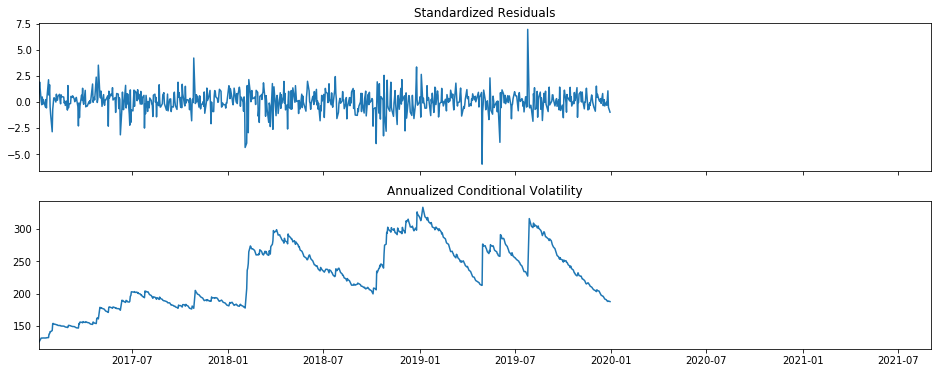

In [15]:
scale_factor = 1000
train = returns[ticker] * scale_factor   # rescale for algorithm to converge

model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
res = model.fit(last_obs='2019-12-31')
print(res.summary())
plt.rc("figure", figsize=(16, 6))
fig = res.plot(annualize='D')
print(res.params, res.tvalues, res._params, res._names)

### GARCH parameters

$\sigma^2_n = \omega + \alpha u^2_{n-1} + \beta \sigma^2_{n-1}$ where $\alpha + \beta < 1$

In [16]:
display(pd.DataFrame(res.params))
persistence = res.params['alpha[1]'] + res.params['beta[1]']
print(f"\npersistence = {persistence:0.3} (speed of mean reversion see Jorion Fig 9-6 page 229)")
print(f"unconditional variance = {res.params['omega'] / ( 1 - persistence): 0.3}")

,params
omega,1.757928
alpha[1],0.019790
beta[1],0.972761



persistence = 0.993 (speed of mean reversion see Jorion Fig 9-6 page 229)
unconditional variance =  2.36e+02


,VaR,returns
Date,,
2018-01-03,-0.019065,0.016280
2018-01-04,-0.019301,0.003615
2018-01-05,-0.019179,0.014466
2018-01-08,-0.019334,0.004264
2018-01-09,-0.019218,-0.000614
...,...,...
2021-08-30,-0.020404,0.006337
2021-08-31,-0.020295,-0.000052
2021-09-01,-0.020135,0.002609


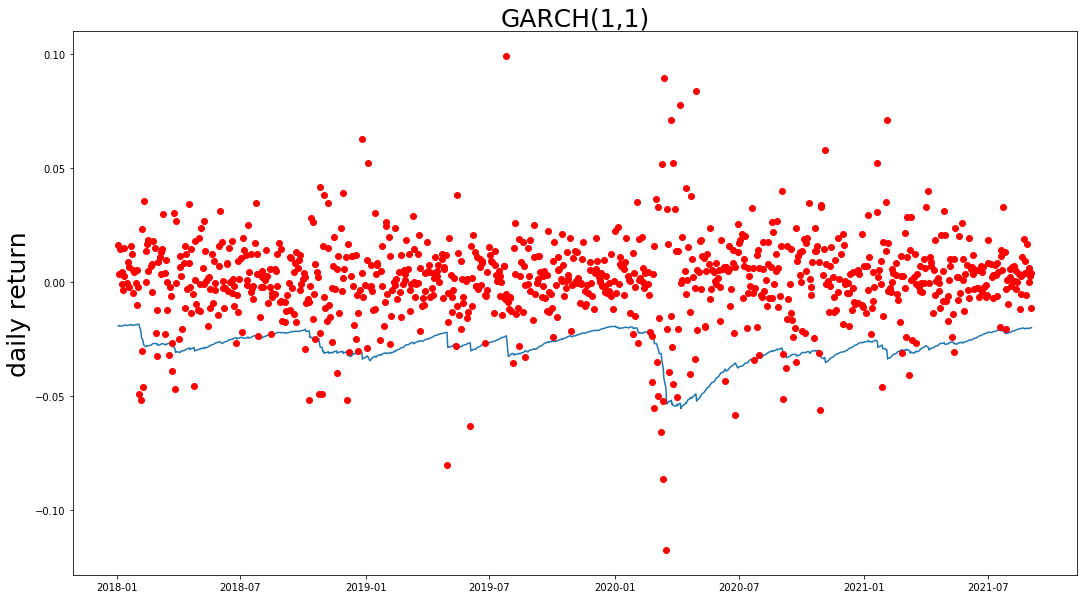

In [17]:
forecasts = res.forecast(start='2018-01-01') # .variance['h.1']

cond_mean = forecasts.mean['2018-01-01':]
cond_var = forecasts.variance['2018-01-01':]
q = model.distribution.ppf([p]) # -1.645 for p=0.05

GARCH_df = pd.DataFrame([-x[0] / scale_factor for x in 
                         (-cond_mean.values - np.sqrt(cond_var).values * q)[:-1]], 
                             index=train['2018-01-01':].index[1:], columns=['VaR'])

GARCH_df['returns'] = train['2018-01-01':] / scale_factor
display(GARCH_df)

plt.figure(figsize=(18,10))
plt.plot(GARCH_df['VaR'])
plt.plot(GARCH_df['returns'], 'ro')
plt.title('GARCH(1,1)', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

In [18]:
scale_factor = 1000

exception_counts = []
for ticker in tickers:
    train = returns[ticker] * scale_factor   # rescale for algorithm to converge

    model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
    res = model.fit(last_obs='2019-12-31')

    forecasts = res.forecast(start='2018-01-01') # .variance['h.1']

    cond_mean = forecasts.mean['2018-01-01':]
    cond_var = forecasts.variance['2018-01-01':]
    q = model.distribution.ppf([p]) # -1.645 for p=0.05

    GARCH_df = pd.DataFrame([-x[0] / scale_factor for x in 
                             (-cond_mean.values - np.sqrt(cond_var).values * q)[:-1]], 
                                 index=train['2018-01-01':].index[1:], columns=['VaR'])

    GARCH_df.loc[:,'returns'] = train['2018-01-01':] / scale_factor

    GARCH2020 = GARCH_df[GARCH_df.index >= '2020-01-01']
    GARCH2020.loc[:,'exception'] = GARCH2020['returns'] < GARCH2020['VaR']
    exception_counts.append( \
        f"{ticker}: number of exceptions = {GARCH2020['exception'].sum()} out of {GARCH2020.shape[0]} days")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3243.5669137710374
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3243.3603158801798
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3242.640948944603
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3235.131303864892
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3233.175667370862
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3232.3933212800375
Iteration:      7,   Func. Count:     44,   Neg. LLF: 3231.8758036682816
Iteration:      8,   Func. Count:     49,   Neg. LLF: 3231.2910948986964
Iteration:      9,   Func. Count:     54,   Neg. LLF: 3231.222259959834
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3231.2081051718305
Iteration:     11,   Func. Count:     64,   Neg. LLF: 3231.2078089829124
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3231.2078079124676
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3231.20780791212
            Iteratio

C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Elliot\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [19]:
exception_counts

['FB: number of exceptions = 22 out of 423 days',
 'AMZN: number of exceptions = 21 out of 423 days',
 'AAPL: number of exceptions = 27 out of 423 days',
 'NFLX: number of exceptions = 17 out of 423 days',
 'GOOG: number of exceptions = 23 out of 423 days']